In [1]:
import sys
sys.path.append("../../../../src")
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from matplotlib import rc
from typing import Union, Tuple, List, Dict, Any

from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.location import Location
from energiapy.components.transport import Transport, VaryingTransport
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.model.constraints.demand import constraint_demand_lb
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.plot import plot_results, plot_scenario
from energiapy.model.solve import solve
from energiapy.utils.scale_utils import scale_tuple

from pyomo.environ import ConcreteModel, Var, NonNegativeReals
from pyomo.environ import value as pyo_val

import pickle
from pyomo.contrib.iis import write_iis
import pickle
import warnings

In [2]:
schedule_time_intervals = 7  # Number of time intervals in a planning horizon
_coms = 1
design_exec_scenarios = 1  # Number of execution scenarios
schedule_exec_scenarios = 52
schedule_planning_horizons = 1

M = 1e4  # Big M

design_annualization_factor = 1/design_exec_scenarios
schedule_annualization_factor = 1/schedule_planning_horizons

In [3]:
def build_schedule_model(start_time: tuple, end_time: tuple, scen_df=pd.DataFrame(), eps: float = 1.0):
    default_df = pd.DataFrame(data=[1] * schedule_exec_scenarios)
    scale_factor = 1
    multiplier = 10

    # Define temporal scales
    scales = TemporalScale(discretization_list=[schedule_planning_horizons, schedule_exec_scenarios, schedule_time_intervals],
                           start_zero=start_time, end_zero=end_time)

    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=500 * scale_factor, block={'imp': 1, 'urg': 1}, price=0.00,
                        label='Commodity 1 consumed from outside the system',
                        varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True,
                         label='Commodity 1 sold to outside the system', varying=[VaryingResource.DETERMINISTIC_DEMAND])

    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 500 * scale_factor * multiplier
    min_process_capacity = 0.01

    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1},
                           capex=25 / scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1},
                        capex=0.1 / scale_factor, vopex=0.01, prod_min=min_process_capacity, label='Sell com1')

    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity,
                                conversion={com1_loc1_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity,
                                conversion={com1_loc2_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity,
                                conversion={com1_loc3_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity,
                                conversion={com1_loc4_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity,
                                conversion={com1_loc5_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity,
                                conversion={com1_loc6_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity,
                                conversion={com1_loc7_out: -1, com1_in: 1}, capex=0.1 / scale_factor, vopex=0.01,
                                prod_min=min_process_capacity, label='Commodity 1 received from location 7')

    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},
                           capex=5 / scale_factor, vopex=0.01, prod_min=min_process_capacity,
                           varying=[VaryingProcess.DETERMINISTIC_CAPACITY],
                           label='Process the commodity through the location')

    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.01 / scale_factor, vopex=5,
                         store_min=0.01, store_max=500 * scale_factor * multiplier, prod_min=min_process_capacity,
                         label="Storage capacity of upto 100 units", storage=com1_in, storage_cost=0.02,
                         storage_capex=50 / scale_factor)

    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc1_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc2_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc3_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc4_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc5_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc6_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc7_out: 1}, capex=0.1 / scale_factor, vopex=0.01,
                             prod_min=min_process_capacity, label='Send commodity one from location 7')

    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1',
                    processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store,
                               com1_loc1_send}, label="Location 1", scales=scales, demand_scale_level=2,
                    capacity_scale_level=1, availability_scale_level=1, availability_factor={
            com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})

    loc2 = Location(name='loc2',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store,
                               com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=2,
                    capacity_scale_level=1, availability_scale_level=1, capacity_factor={
            com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2', 'com1_process') in scen_df else default_df})

    loc3 = Location(name='loc3',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send},
                    label="Location 3", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1)

    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5,
                                            com1_receive_loc7, com1_process, com1_store, com1_loc4_send},
                    label="Location 4", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, capacity_factor={
            com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4', 'com1_process') in scen_df else default_df})

    loc5 = Location(name='loc5', processes={com1_receive_loc1, com1_receive_loc2, com1_receive_loc4,
                                            com1_receive_loc7, com1_process, com1_store, com1_loc5_send, com1_sell},
                    label="Location 5", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, demand_factor={
            com1_sold: scen_df[[('loc5', 'com1_sold')]] if ('loc5', 'com1_sold') in scen_df else default_df})

    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send},
                    label="Location 6", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, availability_factor={
            com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})

    loc7 = Location(name='loc7',
                    processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send},
                    label="Location 7", scales=scales, demand_scale_level=2, capacity_scale_level=1,
                    availability_scale_level=1, capacity_factor={
            com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7', 'com1_process') in scen_df else default_df})

    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================

    truck_cap12 = 140 * scale_factor * multiplier
    truck_cap13 = 60 * scale_factor 
    truck_cap24 = 100 * scale_factor * multiplier
    truck_cap25 = 60 * scale_factor * multiplier
    truck_cap34 = 60 * scale_factor 
    truck_cap45 = 200 * scale_factor * multiplier
    truck_cap47 = 80 * scale_factor * multiplier
    truck_cap64 = 100 * scale_factor * multiplier
    truck_cap75 = 80 * scale_factor * multiplier

    plane_cap15 = 40 * scale_factor
    # plane_cap65 = 40 * scale_factor * multiplier

    truck_capmin = 0.01
    plane_capmin = 0.01

    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12,
                        label='Truck from location 1 to 2', capex=0.5 / scale_factor, vopex=0.05,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12, label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13,
                        label='Truck from location 1 to 3', capex=0.3 / scale_factor, vopex=0.03,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13, label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24,
                        label='Truck from location 2 to 4', capex=0.5 / scale_factor, vopex=0.05,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24, label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25,
                        label='Truck from location 2 to 5', capex=0.3 / scale_factor, vopex=0.03,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25, label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34,
                        label='Truck from location 3 to 4', capex=0.2 / scale_factor, vopex=0.02,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34, label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45,
                        label='Truck from location 4 to 5', capex=1 / scale_factor, vopex=0.1, trans_min=truck_capmin,
                        varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45, label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47,
                        label='Truck from location 4 to 7', capex=0.4 / scale_factor, vopex=0.04,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47, label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64,
                        label='Truck from location 6 to 4', capex=0.5 / scale_factor, vopex=0.05,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64, label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75,
                        label='Truck from location 7 to 5', capex=0.4 / scale_factor, vopex=0.04,
                        trans_min=truck_capmin, varying=[VaryingTransport.DETERMINISTIC_CAPACITY], speed=50)
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75, label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=truck_capmin, speed=50, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])

    plane15 = Transport(name='plane15', resources={com1_loc1_out}, trans_max=plane_cap15,
                        label='Plane from location 1 to 5', capex=3 / scale_factor, vopex=0.5,
                        trans_min=plane_capmin, speed=100)

    # plane65 = Transport(name='plane65', resources={com1_loc6_out}, trans_max=plane_cap65,
    #                     label='Plane from location 6 to 5', capex=1 / scale_factor, vopex=0.5,
    #                     trans_min=plane_capmin, speed=100)

    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [plane15], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, 130, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [130, 112, M, 95, 0, 150, 134],
        [M, M, M, 117, M, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix,
                      transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('truck12', 'com1_loc1_out')]] if ('truck12',
                                                    'com1_loc1_out') in scen_df else default_df},
                                                 
                                                 (loc1, loc3): {truck13: scen_df[[('truck13', 'com1_loc1_out')]] if ( 'truck13', 
                                                    'com1_loc1_out') in scen_df else default_df},
                                                 
                                                 (loc1, loc5): {plane15: scen_df[[('plane15', 'com1_loc1_out')]] if ('plane15', 
                                                    'com1_loc1_out') in scen_df else default_df},
                                                 
                                                 (loc2, loc4): {truck24: scen_df[[('truck24', 'com1_loc2_out')]] if ( 'truck24',
                                                    'com1_loc2_out') in scen_df else default_df},
                                                 
                                                 (loc2, loc5): {truck25: scen_df[[('truck25', 'com1_loc2_out')]] if ('truck25',
                                                    'com1_loc2_out') in scen_df else default_df},
                                                 
                                                 (loc3, loc4): {truck34: scen_df[[('truck34', 'com1_loc3_out')]] if ('truck34',
                                                    'com1_loc3_out') in scen_df else default_df},
                                                 
                                                 (loc4, loc5): {truck45: scen_df[[('truck45', 'com1_loc4_out')]] if ('truck45',
                                                    'com1_loc4_out') in scen_df else default_df},
                                                 
                                                 (loc4, loc7): {truck47: scen_df[[('truck47', 'com1_loc4_out')]] if ('truck47',
                                                    'com1_loc4_out') in scen_df else default_df},
                                                 
                                                 (loc6, loc4): {truck64: scen_df[[('truck64', 'com1_loc6_out')]] if ('truck64',
                                                    'com1_loc6_out') in scen_df else default_df},
                                                 
                                                 (loc7, loc5): {truck75: scen_df[[('truck75', 'com1_loc7_out')]] if ('truck75',
                                                    'com1_loc7_out') in scen_df else default_df},
                                                 })

    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================

    daily_demand = 100 * scale_factor
    demand_penalty = 75
    backlog_penalty = 50

    scenario_demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    backlog_penalty_dict = {i:{com1_sold: backlog_penalty} if i == loc5 else {com1_sold: 0} for i in locset}
    backlog_zero = {loc5:{com1_sold: 34}}
    
    scenario = Scenario(name=f'schedule scenario', scales=scales, scheduling_scale_level=2, network_scale_level=0, purchase_scale_level=2, availability_scale_level=1, demand_scale_level=2, capacity_scale_level=1, network=network, demand=scenario_demand_dict, demand_penalty=demand_penalty_dict, backlog_penalty=backlog_penalty_dict, label='Schedule Scenario', annualization_factor=1/schedule_planning_horizons)

    # ======================================================================================================================
    # Declare model
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.BACKLOG,
                                             Constraints.NETWORK}, demand_sign='eq',
                                objective=Objective.COST_W_DEMAND_PENALTY, backlog_zero=backlog_zero)

    # demand = scenario.demand
    # if isinstance(demand, dict):
    #     if isinstance(list(demand.keys())[0], Location):
    #         try:
    #             demand = {i.name: {
    #                 j.name: demand[i][j] for j in demand[i].keys()} for i in demand.keys()}
    #         except:
    #             pass
    #
    # constraint_demand_lb(instance=problem_mincost, demand=demand, demand_factor=scenario.demand_factor,
    #                      demand_scale_level=scenario.demand_scale_level,
    #                      scheduling_scale_level=scenario.scheduling_scale_level,
    #                      location_resource_dict=scenario.location_resource_dict, epsilon=eps)

    return scenario, problem_mincost

In [4]:
def fix_design_variables(model2fix, design_model, strict=False):
    var_names = ('X_P','Cap_P','X_S','Cap_S','X_F','Cap_F')

    def _fix_from_vars(src, dst):
        if not (src and dst): return
        for k in src:
            val = pyo_val(src[k])
            if val is not None:
                try: dst[k].fix(val)
                except KeyError:
                    if strict: raise

    def _fix_from_dict(dst, data):
        if not dst or dst.name not in data: return
        for i in dst:
            val = data[dst.name].get(i)
            if val is not None: dst[i].fix(float(val))

    if isinstance(design_model, ConcreteModel):
        src_model = (getattr(design_model.ef, next(iter(n for (n, *_) in design_model.scenarios())), design_model)
                     if hasattr(design_model, 'ef') and hasattr(design_model, 'scenarios') else design_model)
        for n in var_names:
            _fix_from_vars(getattr(src_model, n, None), getattr(model2fix, n, None))
    elif isinstance(design_model, dict):
        for n in var_names:
            _fix_from_dict(getattr(model2fix, n, None), design_model)
    else:
        raise TypeError("design_model must be a ConcreteModel or dict")

In [5]:
def fix_scheduling_variables(model2fix, current_time_idx: tuple, initial_dict: dict, time_scales, strict: bool = False):
    """
    Fixes past (or earlier) decision/state variables on `model2fix` using values provided in `initial_dict`.

    Parameters
    ----------
    model2fix :         ConcreteModel       Target Pyomo model whose variables will be fixed.
    current_time_idx :  tuple               The current time index (e.g., (year, week, day, slot) or similar).
    initial_dict :      dict                Mapping { var_name -> { index_tuple -> numeric_value } } that supplies the values to fix.
    time_scales :       object              Must provide `time_scales.scale` (sequence describing temporal granularity).
                                            Used to determine how many trailing integer positions in an index correspond to time for comparison.
    strict :            bool, default=False If True, raise KeyError when a key that should be fixed is not present in `initial_dict`. If False, skip silently but issue a warning.

    Notes
    -----
    - Only variables listed in `states` are considered.
    - A key (index tuple) is fixed if its time part is strictly earlier than `current_time_idx`, or if it is equal at the coarse scale but not the exact
      current slot, and we are not at the very first subperiod (non-zero tail).
    """

    states = {
        'P','B','C','S','R','Inv','P_m','P_material_m', 'Cap_P','Cap_S','Capex_process','Incidental_process','Capex_storage','X_F','Cap_F','Exp','Capex_transport', 'X_P','X_S','X_P_m','Cap_P_m','X_P_mm','Demand_penalty','Demand_penalty_cost','S_demand','S_backlog','Demand_backlog','Demand_backlog_cost'
    }

    vars_to_fix = {v.name: v for v in model2fix.component_objects(Var) if v.name in states}
    zero_tail = (0,) * (len(current_time_idx) - 1)

    def should_fix(idx: tuple) -> bool:
        if idx is None or isinstance(idx, int) or not isinstance(idx, tuple):
            return False
        ints = tuple(e for e in idx if isinstance(e, int))
        L = min(len(time_scales.scale), len(ints))
        if L == 0:
            return False
        tkey = ints[-L:]
        curr = tuple(current_time_idx[:L])
        return (tkey < curr) or (
            tkey == curr
            and current_time_idx[1:] != zero_tail
            and tkey != tuple(current_time_idx)
        )

    for name, var in vars_to_fix.items():
        src_map = initial_dict.get(name, {})
        for k in var.keys():
            if should_fix(k):
                if k not in src_map:
                    msg = f"Missing value for {name}[{k}] in initial_dict"
                    if strict:
                        raise KeyError(msg)
                    else:
                        warnings.warn(msg, UserWarning)
                        continue
                val = src_map[k]
                if val is not None and not var[k].fixed:
                    var[k].fix(float(val))

    print(f"Variables fixed for time {current_time_idx}")

In [6]:
def print_fixed_variables(instance:ConcreteModel):    
    for v in instance.component_objects(Var):
        for index in v:
            if v[index].fixed:
                print(f"{v.name}[{index}]: {v[index].value}")

def get_fixed_variables(instance:ConcreteModel):
    return {v.name: {index: v[index].value for index in v if v[index].fixed} for v in instance.component_objects(Var)}

In [7]:
def supply_chain_controller(time_ind: List, norm_varying_dict: Dict, start_at: Union[int, Tuple] = 0,
    end_at: Union[int, Tuple] = None, initialize_dict: dict = None,        # optional: seed fixes for the first solve
    p_horizon: int = 1,  c_horizon: int = 1, lookback: int = 0, design_model=None, eps: float = 1.0):
    """
    Moving-horizon 'control-only' loop:
    - Builds/solves a fresh model each step.
    - Fixes design variables once at t=start.
    - Fixes past decisions from previous iteration via a small dict.
    - Advances by `c_horizon` and optimizes over a window of length `p_horizon`.

    Returns
    -------
    close_loop_results : dict
        { time_tuple -> { var_name -> {index_tuple -> value} } }
    """
    if c_horizon > p_horizon:
        raise ValueError("c_horizon must be <= p_horizon")

    # Resolve start/end indices whether user passed tuple or integer
    idx_of = lambda x: time_ind.index(x) if isinstance(x, tuple) else int(x)
    start_idx = idx_of(start_at)
    end_idx   = idx_of(end_at if end_at is not None else len(time_ind) - 1)
    if end_idx < start_idx:
        raise ValueError("end_at must be >= start_at")

    close_loop_results = {}
    prev_packet = initialize_dict or {}  # carry-over fixes between iterations

    for t in range(start_idx, end_idx + 1, 1):
        t0 = max(0, t - lookback)
        t1 = min(t + p_horizon, end_idx)
        scen_df = pd.DataFrame({('loc5', 'com1_sold'): norm_varying_dict[t]})  # assumes in scope

        scenario, model = build_schedule_model(start_time=time_ind[t0], end_time=time_ind[t1], eps=eps, scen_df=scen_df)

        # Fix design vars only once (at the first iteration)
        if t == start_idx and design_model is not None:
            fix_design_variables(model2fix=model, design_model=design_model)

        # Fix past decisions from the previous iteration (or initialize_dict on the first pass)
        if prev_packet:
            fix_scheduling_variables(model2fix=model, current_time_idx=time_ind[t], initial_dict=prev_packet, time_scales=scenario.scales, strict=True)

        # Solve
        result = solve(scenario=scenario, instance=model, solver='gurobi', name=f"MILP_{time_ind[t]}")
        
        if result.output['termination'] == 'infeasible':
            print(f"\n### Model infeasible at time {time_ind[t]} - stopping controller loop ###\n")
            return close_loop_results, result, model, scenario

        # Extract values (small, serializable packet)
        packet = {v.name: v.extract_values() for v in model.component_objects(Var)}
        close_loop_results[time_ind[t]] = packet
        prev_packet = packet  # becomes the fixes for the next iteration

        print(f"\n##### Finished {time_ind[t]} of {time_ind[end_idx]} #####\n")

    return close_loop_results, None, None, None

In [8]:
# model_record, scenario_record, results_record = ({} for _ in range(3))

In [9]:
scheduling_scales = TemporalScale(discretization_list=[schedule_planning_horizons, schedule_exec_scenarios, schedule_time_intervals])
scale_iter_list = scheduling_scales.scale_iter(scale_level=len(scheduling_scales.scale)-1)

In [10]:
with open(f'../Round Robin Tests/ef/HPRC_results/final/output_64_10_UI_EF.pkl', 'rb') as file:
    load_output_dict = pickle.load(file)

In [11]:
design_scen = list(load_output_dict.keys())[0]

In [13]:
start_idx = 0
end_idx = len(scale_iter_list)-1

In [14]:
random.seed(2)

In [15]:
demand_dict = dict()
norm_demand_dict = dict()
for i in range(start_idx,end_idx+1):
    if i == start_idx:
        demand_dict[i] = [100]*len(range(start_idx, end_idx+1))
    else:
        demand_dict[i] = demand_dict[i-1][:i] + [round(random.gauss(100,15), 2) for _ in range(len(range(start_idx, end_idx+1))-len(demand_dict[i-1][:i]))]

for i in demand_dict:
    vmax = 100
    norm_demand_dict[i] = [x/vmax for x in demand_dict[i]]

y = demand_dict[5][5:15]
y1 = demand_dict[list(demand_dict.keys())[-1]][:15]
# demand_dict[list(demand_dict.keys())[-1]]

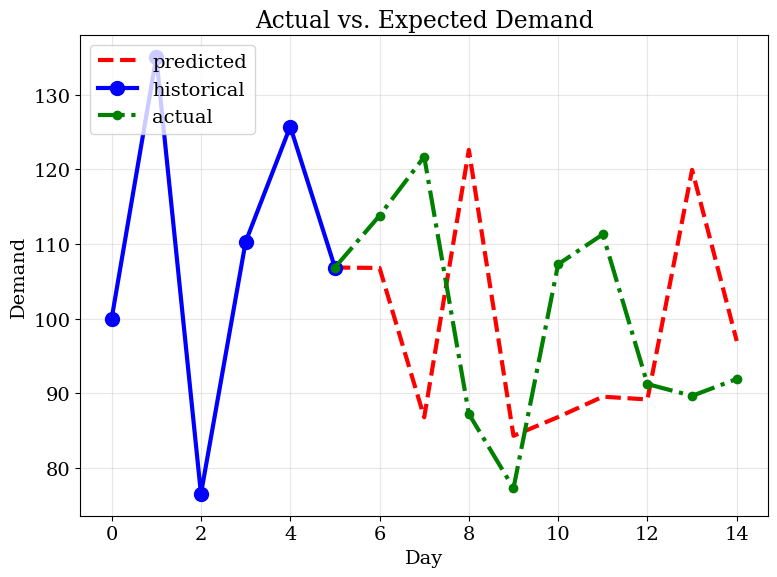

In [16]:
rc('font', **{'family': 'serif', 'size': 14})

fig, ax = plt.subplots(figsize = (8, 6))
x = list(range(5,15))
# Plotting
ax.plot(x, y, marker='', label='predicted', color = 'red', linestyle='--', linewidth = 3)  # 'o' adds circular markers at data points
ax.plot(y1[0:6], marker='o', label='historical', color ='blue', linewidth = 3, markersize=10)
ax.plot(x, y1[5:15], label='actual', color ='green', linewidth = 3, linestyle='-.', marker = 'o')
plt.title('Actual vs. Expected Demand')
plt.ylabel('Demand')
plt.xlabel('Day')
plt.grid(alpha = 0.3)
ax.legend(loc='upper left')
plt.tight_layout()
# plt.savefig(fname = 'contonly0', dpi = 300)
plt.show()
plt.rcdefaults()

In [21]:
close_loop_results, inf_result, inf_model, inf_scenario = supply_chain_controller(time_ind=scale_iter_list, norm_varying_dict=norm_demand_dict, c_horizon=1, p_horizon=10, end_at=(0,10,6), design_model=load_output_dict[design_scen])

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint location capex
constraint location fopex
constraint storage cost
constraint storage capex
constraint storage cost location
constraint storage cost network
constraint production mode
constraint inventory balance
constraint inventory network
constraint resource export
constraint transport export
constraint export
constraint transport capex
constraint transport network capex
constraint transport export network
constraint transport vopex
constraint transport network vopex
constraint transport fopex
constraint transport network fopex
constraint transport capacity UB no bin
constraint transport capacity LB no bin
constraint storage facility
constraint production facility
constraint min production facility
constraint min storage facility
constraint transport capacity UB
constraint transport capacity LB
constraint backlog
constraint backlog total discharge
constraint backlog pena